<h1><center> Question Answering System using Pre-trained model (Simple Transformers) </center></h1>

<h3><center> Oyinlola Jadesola Popoola, x19138202 </center></h3>

<h3><center> Victory Chimamaka Uwaoma, x19210931 </center></h3>

In [ ]:
!pip install PyDrive

In [ ]:
!pip install --user pandas==1.0.3

     |████████████████████████████████| 10.0MB 5.5MB/s 


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded1 = drive.CreateFile({'id':"1eAyT999RWo64LMOW89-H5S3RCUwVl-BU"})   # id of file you want to access
downloaded1.GetContentFile('squad.json')
downloaded2 = drive.CreateFile({'id':"1VoNX3rqw3KXpPYnH0x45prtSq8qH3KpS"})   # id of file you want to access
downloaded2.GetContentFile('train1.json')
downloaded3 = drive.CreateFile({'id':"1uEABHi4YEZ3sD3OqOpdGNxeEaMv1S7DK"})   # id of file you want to access
downloaded3.GetContentFile('dev1.json')

**Import Libraries**

In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
from pandas.io.json import json_normalize


**Load the dataset**

In [ ]:
squad = pd.read_json('squad.json')
train = pd.read_json('train1.json')
dev = pd.read_json('dev1.json')

In [ ]:
squad.head()

,0
0,Dataset
1,"[List, [Association, [Rule, 'Context', 'Archit..."
2,"[TypeSystem`Vector, [TypeSystem`Struct, [List,..."
3,"[Association, [Rule, 'Origin', [HoldComplete, ..."


In [ ]:
print("Shape of data =",squad.shape)

Shape of data = (4, 1)


In [ ]:
train.head()

,data,version
0,"{'title': 'University_of_Notre_Dame', 'paragra...",1.1
1,"{'title': 'Beyoncé', 'paragraphs': [{'context'...",1.1
2,"{'title': 'Montana', 'paragraphs': [{'context'...",1.1
3,"{'title': 'Genocide', 'paragraphs': [{'context...",1.1
4,"{'title': 'Antibiotics', 'paragraphs': [{'cont...",1.1


In [ ]:
print("Shape of data =",train.shape)

Shape of data = (442, 2)


In [ ]:
dev.head()

,data,version
0,"{'title': 'Super_Bowl_50', 'paragraphs': [{'co...",1.1
1,"{'title': 'Warsaw', 'paragraphs': [{'context':...",1.1
2,"{'title': 'Normans', 'paragraphs': [{'context'...",1.1
3,"{'title': 'Nikola_Tesla', 'paragraphs': [{'con...",1.1
4,"{'title': 'Computational_complexity_theory', '...",1.1


In [ ]:
print("Shape of dev data =", dev.shape)

Shape of dev data = (48, 2)


Put dev file in a dataframe to be readable

In [ ]:
#This has multiple answers for same questions unlike traing data
def dtodf(dfile, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    #dfile: path to the squad json file.
    #record_path: path to deepest level in json fil
  
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(dfile).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    m['context'] = idx
    main = m[['id','question','context','answers']].set_index('id').reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [ ]:
dfile = 'dev1.json'
record_path = ['data','paragraphs','qas','answers']
verbose = 0
dev1 = dtodf(dfile=dfile,record_path=record_path)

Reading the json file
processing...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  from ipykernel import kernelapp as app


shape of the dataframe is (10570, 5)
Done


In [ ]:
dev1.head

<bound method NDFrame.head of                              id  ...  c_id
0      56be4db0acb8001400a502ec  ...     0
1      56be4db0acb8001400a502ed  ...     0
2      56be4db0acb8001400a502ee  ...     0
3      56be4db0acb8001400a502ef  ...     0
4      56be4db0acb8001400a502f0  ...     0
...                         ...  ...   ...
10565  5737aafd1c456719005744fb  ...  2066
10566  5737aafd1c456719005744fc  ...  2066
10567  5737aafd1c456719005744fd  ...  2066
10568  5737aafd1c456719005744fe  ...  2066
10569  5737aafd1c456719005744ff  ...  2066

[10570 rows x 5 columns]>

**Put the training json file into a dataframe**

In [ ]:
def ttodf(dfile, record_path = ['data','paragraphs','qas','answers'], verbose = 1):
    #dfile: path to the squad json file.
    #record_path: path to last level in the json file
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(dfile).read())
    if verbose:
        print("processing...")
    # parsing different levels in the json file
    js = pd.json_normalize(file , record_path )
    m = pd.json_normalize(file, record_path[:-1] )
    r = pd.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
    js['q_idx'] = ndx
    main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("Done")
    return main

In [ ]:
dfile = 'train1.json'
record_path = ['data','paragraphs','qas','answers']
train1 = ttodf(dfile=dfile,record_path=record_path)

Reading the json file
processing...
Done


**Checking Structure of the dataset**

In [ ]:
train1.head()

,index,question,context,answer_start,text,c_id
0,5733be284776f41900661182,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha...",515,Saint Bernadette Soubirous,0
1,5733be284776f4190066117f,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic cha...",188,a copper statue of Christ,0
2,5733be284776f41900661180,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...",279,the Main Building,0
3,5733be284776f41900661181,What is the Grotto at Notre Dame?,"Architecturally, the school has a Catholic cha...",381,a Marian place of prayer and reflection,0
4,5733be284776f4190066117e,What sits on top of the Main Building at Notre...,"Architecturally, the school has a Catholic cha...",92,a golden statue of the Virgin Mary,0



**Text Data Pre-processing**

Data dimensions

In [ ]:
print("Shape of data =", train1.shape)
#the dataset contains 87599 rows and 6 columns, we drop the columns that are not needed

Shape of data = (87599, 6)


Checking for Null values

In [ ]:
train1.isnull().sum()
#no null values

index           0
question        0
context         0
answer_start    0
text            0
c_id            0
dtype: int64

In [ ]:
#take a look at the text present in the columns
train1['question'].unique()

array(['To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
       'What is in front of the Notre Dame Main Building?',
       'The Basilica of the Sacred heart at Notre Dame is beside to which structure?',
       ...,
       'With what Belorussian city does Kathmandu have a relationship?',
       'In what year did Kathmandu create its initial international relationship?',
       'What is KMC an initialism of?'], dtype=object)

In [ ]:
train1['context'].unique()

array(['Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
       "As at most other universities, Notre Dame's students run a number of news media outlets. The nine student-run outlets include three newspapers, both a radio and television station, and several magazines and journals. Begun as a one-page journal in September 1876, the Scholastic magazi

In [ ]:
train1['text'].unique()

array(['Saint Bernadette Soubirous', 'a copper statue of Christ',
       'the Main Building', ..., 'Oregon', 'Minsk',
       'Kathmandu Metropolitan City'], dtype=object)

**Cleaning Text Data for word embeddings**

When cleaning the text, we will perform the following task

1.   Convert text to lowercase
2.   Remove punctuations
3.   Remove extra space



1. Convert text to lowercase (because in NLP casing matters)


In [ ]:
train1['clean_question']=train1['question'].apply(lambda x: x.lower())
train1['clean_context']=train1['context'].apply(lambda x: x.lower())
train1['clean_text']=train1['text'].apply(lambda x: x.lower())

2. Removing punctuations

In [ ]:
import re
import string
train1['clean_question']=train1['clean_question'].str.replace('[^\w\s]','')
train1['clean_context']=train1['clean_context'].str.replace('[^\w\s]','')
train1['clean_text']=train1['clean_text'].str.replace('[^\w\s]','')

3. Removing extra space

In [ ]:
train1['clean_question']=train1['clean_question'].apply(lambda x: re.sub(' +',' ',x))
train1['clean_context']=train1['clean_context'].apply(lambda x: re.sub(' +',' ',x))
train1['clean_text']=train1['clean_text'].apply(lambda x: re.sub(' +',' ',x))

Checking

In [ ]:
train1['clean_question'].unique()

array(['to whom did the virgin mary allegedly appear in 1858 in lourdes france',
       'what is in front of the notre dame main building',
       'the basilica of the sacred heart at notre dame is beside to which structure',
       ...,
       'with what belorussian city does kathmandu have a relationship',
       'in what year did kathmandu create its initial international relationship',
       'what is kmc an initialism of'], dtype=object)

In [ ]:
train1['clean_context'].unique()

array(['architecturally the school has a catholic character atop the main buildings gold dome is a golden statue of the virgin mary immediately in front of the main building and facing it is a copper statue of christ with arms upraised with the legend venite ad me omnes next to the main building is the basilica of the sacred heart immediately behind the basilica is the grotto a marian place of prayer and reflection it is a replica of the grotto at lourdes france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858 at the end of the main drive and in a direct line that connects through 3 statues and the gold dome is a simple modern stone statue of mary',
       'as at most other universities notre dames students run a number of news media outlets the nine studentrun outlets include three newspapers both a radio and television station and several magazines and journals begun as a onepage journal in september 1876 the scholastic magazine is issued twice monthly a

In [ ]:
train1['clean_text'].unique()

array(['saint bernadette soubirous', 'a copper statue of christ',
       'the main building', ..., 'oregon', 'minsk',
       'kathmandu metropolitan city'], dtype=object)

Statistically checking the data

In [ ]:
train1['clean_question'].describe()

count                                                 87599
unique                                                87320
top       which caribbean nation is in the top quartile ...
freq                                                      6
Name: clean_question, dtype: object

In [ ]:
train1['clean_context'].describe()

count                                                 87599
unique                                                18889
top       in 1853 victoria gave birth to her eighth chil...
freq                                                     25
Name: clean_context, dtype: object

In [ ]:
train1['clean_text'].describe().head()

count     87599
unique    63265
top       three
freq        244
Name: clean_text, dtype: object

In [ ]:
#dropping columns
train1 = train1.drop(train1.columns[[0, 1, 2, 4, 5]], axis=1) 

In [ ]:
train1.head()

,answer_start,clean_question,clean_context,clean_text
0,515,to whom did the virgin mary allegedly appear i...,architecturally the school has a catholic char...,saint bernadette soubirous
1,188,what is in front of the notre dame main building,architecturally the school has a catholic char...,a copper statue of christ
2,279,the basilica of the sacred heart at notre dame...,architecturally the school has a catholic char...,the main building
3,381,what is the grotto at notre dame,architecturally the school has a catholic char...,a marian place of prayer and reflection
4,92,what sits on top of the main building at notre...,architecturally the school has a catholic char...,a golden statue of the virgin mary


In [ ]:
print(train1.loc[[0]])

   answer_start  ...                  clean_text
0           515  ...  saint bernadette soubirous

[1 rows x 4 columns]


**Wordcloud**

In [ ]:
!pip install wordcloud

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import sys

Wordcloud for Questions 

In [ ]:
wordcloud1 = WordCloud().generate(' '.join(train1['clean_question']))

In [ ]:
WordCloud.generate_from_frequencies

<function wordcloud.wordcloud.WordCloud.generate_from_frequencies>

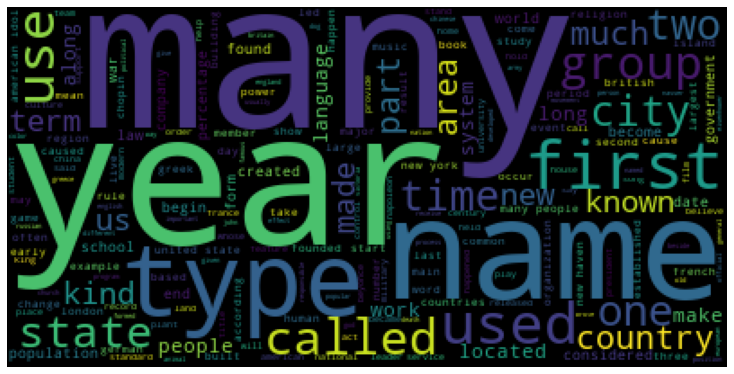

In [ ]:
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

Wordcloud for Contexts 

In [ ]:
wordcloud2 = WordCloud().generate(' '.join(train1['clean_context']))

In [ ]:
WordCloud.generate_from_frequencies

<function wordcloud.wordcloud.WordCloud.generate_from_frequencies>

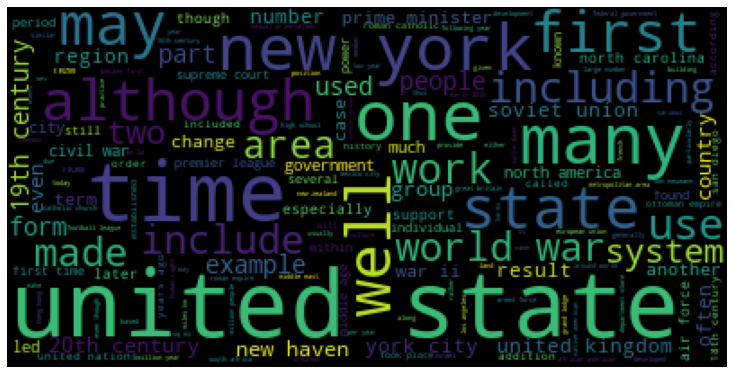

In [ ]:
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

Wordcloud for Answers

In [ ]:
wordcloud3 = WordCloud().generate(' '.join(train1['clean_text']))

In [ ]:
WordCloud.generate_from_frequencies

<function wordcloud.wordcloud.WordCloud.generate_from_frequencies>

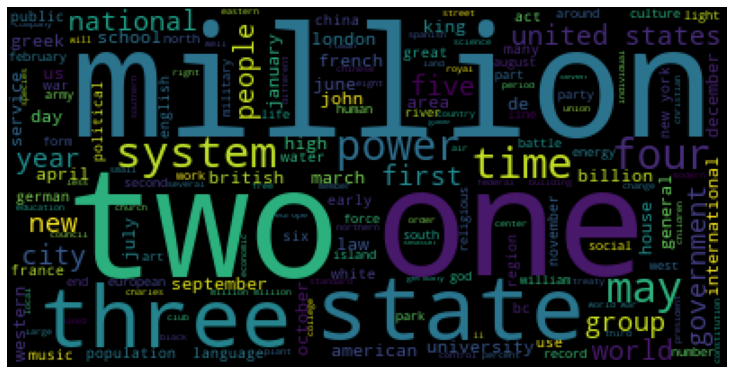

In [ ]:
plt.figure(figsize = (10, 10), facecolor = None ) 
plt.imshow(wordcloud3) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

**Word Embeddings**

Using word2vec for word embeddings:

using pretrained word embedding vector because of sparsity of training data and large no of parameters


In [ ]:
import os
import nltk
import gensim
#training the model using Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html
import multiprocessing

from gensim.models import Word2Vec

#making the columns as list of words for input
list_context = [row.split() for row in train1['clean_context']]
list_question = [row.split() for row in train1['clean_question']]
list_text = [row.split() for row in train1['clean_text']]

In [ ]:
type(list_context)
type(list_question)
type(list_text)

list

In [ ]:
#Word2Vec
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

w2v_context = Word2Vec(min_count=1,
                     window=2,
                     size=32,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)


In [ ]:
#building vocab table for context
w2v_context.build_vocab(list_context, progress_per=10000)


In [ ]:
#training
w2v_context.train(list_context, total_examples=w2v_context.corpus_count, epochs=30, report_delay=1)

In [ ]:
#replace is set at false to forget original vectors and only keep normalized to save memeory
w2v_context.init_sims(replace=True)

In [ ]:
#exploring
w2v_context.wv.most_similar(positive=["york"])

In [ ]:
#to see how similar words are to each other
w2v_context.wv.similarity('genocide', 'who')

In [ ]:
#odd one out
w2v_context.wv.doesnt_match(['catholic', 'new', 'york'])

In [ ]:
context_vocabsize=len(w2v_context.wv.vocab)
context_vocabsize

In [ ]:
#Word2Vec
w2v_question= Word2Vec(min_count=1,
                     window=2,
                     size=32,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [ ]:
#building vocab table for question
w2v_question.build_vocab(list_question, progress_per=10000)

In [ ]:
#training
w2v_question.train(list_question, total_examples=w2v_question.corpus_count, epochs=30, report_delay=1)

In [ ]:
#replace is set at false to forget original vectors and only keep normalized to save memeory
w2v_question.init_sims(replace=True)

In [ ]:
#exploring the model
w2v_question.wv.most_similar(positive=["many"])

In [ ]:
#to see how similar words are to each other
w2v_question.wv.similarity('what', 'who')

In [ ]:
#odd one out
w2v_question.wv.doesnt_match(['catholic', 'church', 'york'])

In [ ]:
question_vocabsize=len(w2v_question.wv.vocab)
question_vocabsize

Transfer learning


In [64]:
#using pre-trained transformer models using the simple transformers library from the huggingface transformers https://github.com/huggingface/transformers 
!pip install wandb
!pip install transformers
!pip install seqeval
!pip install tensorboardx
!pip install simpletransformers 

from simpletransformers.question_answering import QuestionAnsweringModel


train_args = {
    'learning_rate': 3e-5,
    'num_train_epochs': 2,
    'max_seq_length': 384,
    'doc_stride': 128,
    'overwrite_output_dir': True,
    'reprocess_input_data': False,
    'train_batch_size': 2,
    'gradient_accumulation_steps': 8,
}

model = QuestionAnsweringModel('bert', 'bert-base-cased', args=train_args)
#bert is model type and bert-base-cased is the model name



     |████████████████████████████████| 1.4MB 3.5MB/s 
     |████████████████████████████████| 122kB 21.7MB/s 
     |████████████████████████████████| 163kB 17.3MB/s 
     |████████████████████████████████| 102kB 9.0MB/s 
     |████████████████████████████████| 102kB 8.5MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=e5d2d253207200a18c0f3c91dd5b7e54d5164a2376222de16dfcc9d8467fbe65
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73870 sha256=f1d9f1c94d87733a46a2dc810fc6c0381df603393e33ccfb4828c644def69940
  Stored in directory: /root/.cache/pip/wheels/a8/1d/38/2c19bb311f67cc7b4d07a2ec5ea36ab1a0a0ea50db994a5bc7
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=09c9

     |████████████████████████████████| 778kB 3.5MB/s 
     |████████████████████████████████| 890kB 10.8MB/s 
     |████████████████████████████████| 3.0MB 36kB/s 
     |████████████████████████████████| 1.1MB 32.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=f7cc42e334efd477639d8e9a6a04f16fada5cf0e4eb597f79126c0a8e7ef79c5
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=c95cd43c020ee3e918637cfbb98ee3366ce1903fd23d9d94240f6955e4b7b50b
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval
     |████████████████████████████████| 317kB 3.5MB/s 
     |████████████████████████████████| 215kB 3.5MB/s 
     |████████████████████████████████| 71kB 5.0MB/s 
     |████████████████████████

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and a

In [65]:
#converting the json files to list of dictionary which is the suitable format to perform QA in simple transformers
train = [item for topic in train['data'] for item in topic['paragraphs'] ]

type(train)

list

In [66]:
len(train)

18896

In [67]:
#getting a random sample for training
import random
random.seed(3)
randomtrain=random.sample(train, 5000)


In [68]:
len(randomtrain)

5000

In [69]:
remain = [ele for ele in train if ele not in randomtrain]
len(remain) 

13896

In [70]:
#getting a random sample for testing
random.seed(6)
randomtest=random.sample(remain, 1000)

In [71]:
import sklearn
model.train_model(randomtrain, acc=sklearn.metrics.accuracy_score)


add example index and unique id: 100%|██████████| 23310/23310 [00:00<00:00, 749206.70it/s]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Evaluation

In [72]:
import sklearn
result, text= model.eval_model(randomtest, acc=sklearn.metrics.accuracy_score, verbose= True)
print(result)#contains evaluation result
print(text)#a dict containing the the correct_text, similar_text and incorrect text

add example index and unique id: 100%|██████████| 4657/4657 [00:00<00:00, 648566.38it/s]



{'correct': 2684, 'similar': 1351, 'incorrect': 622, 'acc': 0.576336697444707, 'eval_loss': -8.06042399791756}
{'correct_text': {'5730e860b54a4f140068ccda': 'Department of Defense', '5730e860b54a4f140068ccdb': 'three', '5730e860b54a4f140068ccdd': 'Marine Corps', '5730e860b54a4f140068ccde': 'Captain Chuck Yeager', '5727f4544b864d1900164099': '150 mA', '5731dedd0fdd8d15006c65ce': 'secondary', '5731dedd0fdd8d15006c65cf': 'idiosyncratic', '5726b44edd62a815002e8d70': 'Pitt', '5726b44edd62a815002e8d72': 'Arthur Young', '5726b44edd62a815002e8d74': '1800', '57343a9f4776f41900661aa8': 'Jackson Ward', '57343a9f4776f41900661aa9': 'Monument Avenue', '57064d5075f01819005e7b2a': 'ID3v2', '57064d5075f01819005e7b2b': 'APEv2', '56ce6efbaab44d1400b88787': 'Urban heat islands', '56d0817d234ae51400d9c334': 'Urban heat islands', '56d0817d234ae51400d9c335': 'asphalt and concrete', '56d0817d234ae51400d9c336': 'paint buildings and roads white and plant trees', '5733b2fe4776f41900661092': '1950', '5733b2fe477

Prediction

In [73]:
import sklearn
dev = [item for topic in dev['data'] for item in topic['paragraphs'] ]
predtn1, raw_outputs = model.predict(dev, n_best_size=2)#return a list of dict containg each question mapped to its answer and a list of dicts of question id mapped to probability score of the answer

predtn1[0]



add example index and unique id: 100%|██████████| 10570/10570 [00:00<00:00, 682898.85it/s]


{'answer': ['Denver Broncos',
  'Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers'],
 'id': '56be4db0acb8001400a502ec'}

In [74]:
raw_outputs[0]

{'id': '56be4db0acb8001400a502ec',
 'probability': [0.844224857191274, 0.15577514280312765]}

In [75]:
context_text = "Linear regression is used for predicting quantitative values, such as an individual’s salary. In order to predict qualitative values, such as whether a patient survives or dies, or whether the stock market increases or decreases, Fisher proposed linear discriminant analysis in 1936."
predtn2, raw_outputs = model.predict(
    [
        {
            "context": context_text,
            "qas": [
                {
                    "question": "Who proposed linear discriminant analysis?",
                    "id": "0",
                }
            ],
        }
    ],
n_best_size=2)

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2495.12it/s]


In [76]:
print(predtn2)#return a list of dict containg each question mapped to its answer 

print(raw_outputs)#a list of dicts of question id mapped to probability score of the answer


[{'id': '0', 'answer': ['Fisher', 'Fisher proposed linear discriminant analysis in 1936']}]
[{'id': '0', 'probability': [0.9996950658424102, 0.0003049341574679109]}]


In [77]:
context_text = "Thomas Alva Edison was an American inventor and businessman who has been described as America's greatest inventor.One of his inventions, is the phonograph"
predtn3, raw_outputs = model.predict(
    [
        {
            "context": context_text,
            "qas": [
                {
                    "question": "Who invented phonograph?",
                    "id": "0",
                }
            ],
        }
    ],
n_best_size=2)

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2801.81it/s]


In [78]:
print(predtn3)#return a list of dict containg each question mapped to its answer 

print(raw_outputs)#a list of dicts of question id mapped to probability score of the answer


[{'id': '0', 'answer': ['Thomas Alva Edison', 'Thomas']}]
[{'id': '0', 'probability': [0.9974381710285595, 0.0025618289713594147]}]


In [79]:
context_text = "Mary drove for 3 hours to work in the morning and 5 hours in the evening to her house"
predtn4, raw_outputs = model.predict(
    [
        {
            "context": context_text,
            "qas": [
                {
                    "question": "How many hours did Mary drive for today?",
                    "id": "0",
                }
            ],
        }
    ],
n_best_size=2)

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 668.41it/s]


In [80]:
print(predtn4)#return a list of dict containg each question mapped to its answer 

print(raw_outputs)#a list of dicts of question id mapped to probability score of the answer


[{'id': '0', 'answer': ['3', '3 hours']}]
[{'id': '0', 'probability': [0.7113530743137343, 0.2886469255831411]}]
